In [21]:
import regex as re
import gc
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# Loading the merged train and test dataset

train_data = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/ieee-fraud-detection/Data/merged_train.pkl')
test_data = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/ieee-fraud-detection/Data/merged_test.pkl')

In [24]:
def cat_num_features(df):
    
    '''
        Utility Function to get the names of Categorical Features and 
        Numerical Features of the given Dataset.
    '''
    
    catf = []
    numf = []
    
    # Given Categorical Features 
    catf = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', \
            'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', \
            'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', \
            'DeviceType', 'DeviceInfo']
    catf+=['id_'+str(i) for i in range(12,39)]


    # Updating the Categorical Feature Names List based on the columns present in the dataframe
    catf = [feature for feature in catf if feature in df.columns.values]
    numf = [feature for feature in df.columns if feature not in catf and not feature == 'isFraud']
    
    return (catf, numf)  

In [25]:
def label_encode(X_train, X_test, catf):
  
  '''
    Utility Function to Encode Categorical Features.
  '''

  for f in catf:
    
    X_train[f] = X_train[f].astype(str)
    
    le = LabelEncoder()
    le.fit(X_train[f])
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    X_train[f] = le.transform(X_train[f])

    # Manually Encoding the CV and Test Dataset so as to avoid error for any category which is not present in train set
    
    # All the categories which are not present in train datset are encoded as -1
    
    X_test[f] = [-1 if mapping.get(v, -1)==-1 else mapping[v] for v in X_test[f].values ]
    
  return (X_train, X_test)

In [26]:
def tpr_fpr_threshold_auc(Y, proba):
    
    '''
        Utility Function to return fpr, tpr, threshold and roc_auc.
    '''
    
    fpr, tpr, threshold = sklearn.metrics.roc_curve(Y, proba)
    roc_auc = metrics.auc(fpr, tpr)
    
    return (fpr, tpr, threshold, roc_auc)

def train_cv_auc(train_fpr, train_tpr, train_roc_auc, cv_fpr, cv_tpr, cv_roc_auc):

    '''
        Utility Function to Draw ROC-AUC Curves for Train and Validation Datasets.
    '''
    
    plt.title('\nReceiver Operating Characteristic\n')
    plt.plot(train_fpr, train_tpr, label = 'Train AUC = %0.2f' % train_roc_auc)
    plt.plot(cv_fpr, cv_tpr, label = 'CV AUC = %0.2f' % cv_roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate (TPR)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.show()

def best_threshold(threshold,tpr,fpr):
    
    '''
        Utility Function to return the best threshold value based on the TPR and FPR values.
    '''
    
    return threshold[np.argmax(tpr*(1-fpr))];


def class_label(best_thr, pred_score):
    
    '''
        Utility Function to return the class label based on the chosen threshold.
    '''
    return np.where(pred_score>best_thr,1,0);


def draw_confusion_matrix(Y, predicted):
    
    '''
        Utility Function to draw Confusion Matrix.
    '''

    cv_cm = metrics.confusion_matrix(Y, predicted)
    sns.heatmap(cv_cm, annot=True,fmt="d",cmap='Oranges', xticklabels=['Legit', 'Fraudulent'], yticklabels=['Legit', 'Fraudulent'])
    plt.title('\nConfusion  Matrix\n')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()

In [27]:
#Setting up data for PCA
needed_train_data = train_data.drop(['isFraud', 'TransactionID'], axis=1)
needed_test_data = test_data.drop(['TransactionID'], axis=1)
output_label_data = train_data['isFraud']

catf, numf = cat_num_features(needed_train_data)

needed_train_data[catf] = needed_train_data[catf].fillna('missing')
needed_test_data[catf] = needed_test_data[catf].fillna('missing')

needed_train_data, needed_test_data = label_encode(needed_train_data, needed_test_data, catf)
needed_test_data = needed_test_data.fillna(-999)
needed_train_data = needed_train_data.fillna(-999)

scaler = StandardScaler ()
needed_train_data_scalr = scaler.fit_transform(needed_train_data)
needed_test_data_scalr = scaler.fit_transform(needed_test_data)

In [28]:
del train_data, test_data, needed_train_data, needed_test_data

In [29]:
%%time 

from sklearn.decomposition import PCA

feature_selector = PCA (n_components=40)

feature_selector = feature_selector.fit(needed_train_data_scalr)

CPU times: user 56.4 s, sys: 8 s, total: 1min 4s
Wall time: 41.7 s


In [30]:
print ('\n each pca component length : ',  len(feature_selector.components_[0]))
print ('\n pca.components_ :\n',  len(feature_selector.components_))
print ('\n pca.explained_variance_ratio_ : ' , feature_selector.explained_variance_ratio_)


 each pca component length :  432

 pca.components_ :
 40

 pca.explained_variance_ratio_ :  [0.44359068 0.09278544 0.08069043 0.06152135 0.02741466 0.02728756
 0.02425061 0.02089118 0.01860973 0.01832195 0.01612313 0.01418196
 0.01162823 0.01010249 0.00805422 0.00652938 0.00586767 0.00548363
 0.00501564 0.0047134  0.00451866 0.00430216 0.00351459 0.00332693
 0.0029459  0.00287413 0.00280685 0.00273595 0.00266224 0.00249076
 0.0023792  0.00235953 0.0023387  0.00226861 0.00222541 0.00217563
 0.00205945 0.00194838 0.00188415 0.00179386]


In [32]:
X_train, X_cv, y_train, y_cv = train_test_split(needed_train_data_scalr, output_label_data, test_size=0.20, shuffle=False)

In [33]:
X_train_pca = feature_selector.transform(X_train)
X_cv_pca = feature_selector.transform(X_cv)
X_test_pcatranform = feature_selector.transform(needed_test_data_scalr)

In [34]:
%%time
clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=3000,
    nthread=4,
    tree_method='hist',
    random_state=3,
    subsample=0.8,
    max_depth=12,
    colsample_bytree=0.6,
    learning_rate=0.02
)

results = clf.fit(X_train_pca, y_train, eval_set=[(X_cv_pca, y_cv)], verbose=50, early_stopping_rounds=100)

[0]	validation_0-auc:0.78599
[50]	validation_0-auc:0.83251
[100]	validation_0-auc:0.84179
[150]	validation_0-auc:0.84719
[200]	validation_0-auc:0.85070
[250]	validation_0-auc:0.85405
[300]	validation_0-auc:0.85584
[350]	validation_0-auc:0.85709
[400]	validation_0-auc:0.85813
[450]	validation_0-auc:0.85826
[500]	validation_0-auc:0.85857
[550]	validation_0-auc:0.85848
[600]	validation_0-auc:0.85846
[635]	validation_0-auc:0.85860
CPU times: user 8min 17s, sys: 3.29 s, total: 8min 20s
Wall time: 5min 7s


In [35]:
train_proba = clf.predict_proba(X_train_pca)[:,1]
cv_proba = clf.predict_proba(X_cv_pca)[:,1]
test_proba = clf.predict_proba(X_test_pcatranform)[:,1]

In [36]:
train_fpr, train_tpr, train_threshold, train_roc_auc = tpr_fpr_threshold_auc(y_train, train_proba)
cv_fpr, cv_tpr, cv_threshold, cv_roc_auc = tpr_fpr_threshold_auc(y_cv, cv_proba)

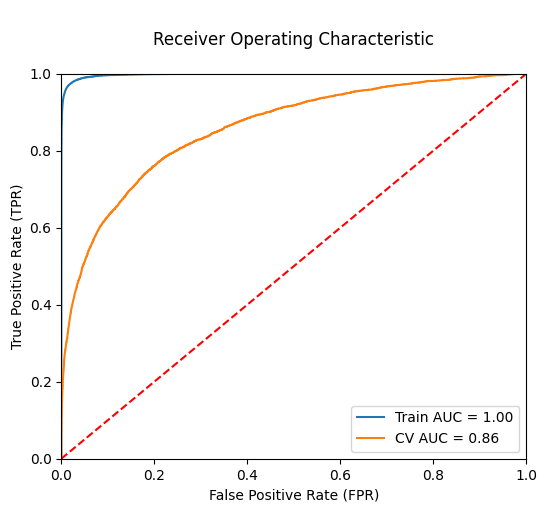

In [37]:
plt.rcParams["figure.figsize"] = (6, 5)
train_cv_auc(train_fpr, train_tpr, train_roc_auc, cv_fpr, cv_tpr, cv_roc_auc)

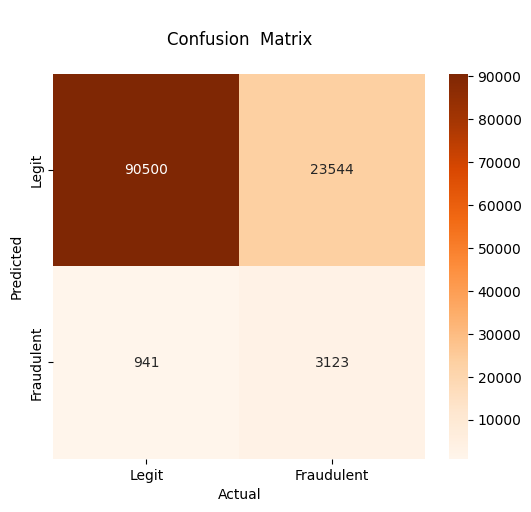

In [38]:
best_thr = best_threshold(cv_threshold, cv_tpr, cv_fpr)
cv_pred = class_label(best_thr, cv_proba)

draw_confusion_matrix(y_cv, cv_pred)